In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
train_data_dir = 'chest_xray/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
test_data_dir = 'chest_xray/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [4]:
val_data_dir = 'chest_xray/chest_xray/val'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

In [5]:
all_xray_df = pd.read_csv('build_vit_model/input/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in
                      glob(os.path.join('build_vit_model/input', 'images*', '*', '*.png'))
                  }
all_xray_df['filepaths'] = all_xray_df['Image Index'].map(all_image_paths.get)

filtered_df = all_xray_df[all_xray_df['Finding Labels'] == 'Pneumonia']

no_finding_df = all_xray_df[all_xray_df['Finding Labels'] == 'No Finding']
sampled_no_finding_df = no_finding_df.sample(n=3012, random_state=42) 

result_df_1 = filtered_df[['filepaths']].copy() 
result_df_1['labels'] = 'Pneumonia'

result_df_2 = sampled_no_finding_df[['filepaths']].copy() 
result_df_2['labels'] = 'NORMAL'

train_df = pd.concat([train_df, result_df_1], axis=0, ignore_index=True)
train_df = pd.concat([train_df, result_df_2], axis=0, ignore_index=True)
print('LẤY THÊM BỆNH VIÊM PHỔI :',result_df_1.shape[0])
print('LẤY THÊM KHÔNG BỊ BỆNH: ',result_df_2.shape[0])

LẤY THÊM BỆNH VIÊM PHỔI : 322
LẤY THÊM KHÔNG BỊ BỆNH:  3012


In [6]:
train_df['labels'] = train_df['labels'].apply(lambda x: 0 if x == 'NORMAL' else 1)

In [7]:
train_df, temp_df = train_test_split(train_df, 
                                     test_size=0.2, 
                                     random_state=0, 
                                     stratify=train_df['labels']
                                    )
valid_df, test_df = train_test_split(temp_df, 
                                     test_size=0.5, 
                                     random_state=0, 
                                     stratify=temp_df['labels']
                                    )

In [8]:
test_labels = test_df['labels'].values 
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0],'test_label', test_labels.shape[0])


train 7352 validation 919 test 919 test_label 919


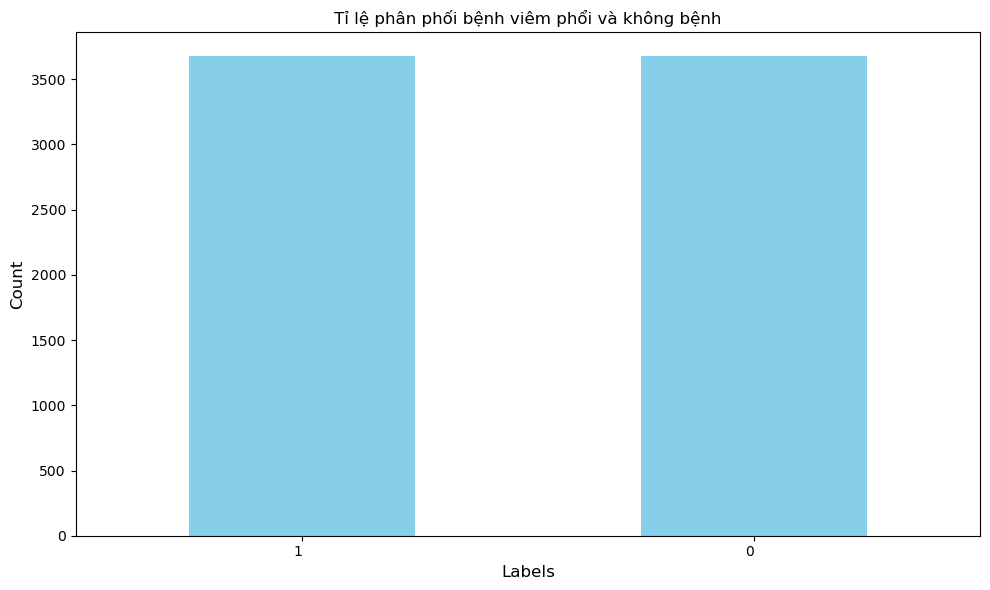

In [9]:
label_counts = train_df['labels'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color= 'skyblue')
plt.title('Tỉ lệ phân phối bệnh viêm phổi và không bệnh')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (28,28)
TRAIN_BATCH_SIZE = 32
# VALID_TEST_BATCH_SIZE = valid_df.shape[0]
VALID_TEST_BATCH_SIZE = 32
core_idg = ImageDataGenerator(
                            rescale=1./255,
                              horizontal_flip=True,
                              vertical_flip=False,
                              height_shift_range=0.2,
                              width_shift_range=0.2,
                              rotation_range=40,
                              shear_range=0.2,
                              fill_mode='reflect',
                              zoom_range=0.2
                             )


In [11]:
train_gen = core_idg.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filepaths',
    y_col= 'labels',          
    target_size=IMG_SIZE,
    class_mode='raw',        
    batch_size=TRAIN_BATCH_SIZE,
    color_mode='grayscale',
    shuffle=True,  
    seed=42,
    # weight_col='sample_weights'
)


Found 7352 validated image filenames.


In [12]:

image_generator = ImageDataGenerator(
    rescale=1./255
)



In [13]:
valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='filepaths',
    y_col= 'labels',          
    target_size=IMG_SIZE,
    class_mode='raw',        
    batch_size=VALID_TEST_BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False,  
    seed=42 
)



Found 919 validated image filenames.


In [14]:
test_gen = image_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='filepaths',
    y_col= 'labels',          
    target_size=IMG_SIZE,
    class_mode='raw',        
    batch_size=VALID_TEST_BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False,  
    seed=42 
)

Found 919 validated image filenames.


In [15]:
def process_train_gen(train_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(train_gen)
      
        yield x_batch, y_batch

def process_valid_test_gen(valid_test_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(valid_test_gen)
        
        yield x_batch, y_batch

train_gen = process_train_gen(train_gen)
valid_gen = process_valid_test_gen(valid_gen)
test_gen = process_valid_test_gen(test_gen)

In [16]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# kernel_regularizer = l2(0.001)
# from tensorflow.keras.regularizers import l2 
from keras.src.layers import Layer, Dense
import keras as kr
import tensorflow as tf

class Patches (Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]

    patches = tf.image.extract_patches(
      images=images,
      sizes=[1, self.patch_size, self.patch_size, 1],
      strides=[1, self.patch_size, self.patch_size, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'
    )

    dim = patches.shape[-1]

    patches = tf.reshape(patches, (batch_size, -1, dim))

    return patches
  
class PatchEmbedding(Layer):
  def __init__(self, patch_size, image_size, projection_dim):
    super(PatchEmbedding, self).__init__()

    self.num_patches = (image_size // patch_size) **2

    self.cls_token = self.add_weight(
      name="cls_token",
      shape=[1, 1, projection_dim],
      initializer= kr.initializers.RandomNormal(),
      dtype= tf.float32
    )

    self.patches = Patches(patch_size)

    self.projection = Dense(units = projection_dim)

    self.position_embdding = self.add_weight(
      name="position_embeddings",
      shape=[self.num_patches +1, projection_dim],
      initializer= kr.initializers.RandomNormal(),
      dtype=tf.float32
    )

  def call(self, images):
    patch= self.patches(images)

    encoded_patches = self.projection(patch)

    batch_size =  tf.shape(images)[0]

    hidden_size = tf.shape(encoded_patches)[-1]

    cls_broadcasted = tf.cast(
      tf.broadcast_to(self.cls_token, [batch_size, 1, hidden_size]),
      dtype=images.dtype
    )

    encoded_patches = tf.concat([cls_broadcasted, encoded_patches], axis=1)

    encoded_patches += self.position_embdding

    return encoded_patches    

In [17]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from keras.src.layers import Layer, LayerNormalization, MultiHeadAttention, Dense, Dropout
from keras import Sequential

import tensorflow as tf

class MLPBlock(Layer):
  def __init__(self, hidden_layers, dropout = 0.1, activation= 'gelu'):
    super(MLPBlock, self).__init__()

    layers= []
    for num_units in hidden_layers:
      layers.extend([
        Dense(num_units, activation= activation),
        Dropout(dropout)
      ])

    self.mlp = Sequential(layers)

  def call(self, inputs):
    outputs= self.mlp(inputs)
    return outputs

class TransformerBlock(Layer):
  def __init__(self, num_heads, D, hidden_layers, dropout= 0.1, norm_eps= 1e-12):
    super(TransformerBlock, self).__init__()

    self.norm = LayerNormalization(epsilon=norm_eps)

    self.attention = MultiHeadAttention(
      num_heads=num_heads, key_dim=D // num_heads, dropout=dropout
    )

    self.mlp= MLPBlock(hidden_layers, dropout)

  def call(self, inputs):
    norm_attention = self.norm(inputs)

    attention = self.attention(query= norm_attention, value = norm_attention)
    
    attention += inputs
    
    outputs= self.mlp(self.norm(attention))

    outputs += attention

    return outputs
  
class TransformerEncoder(Layer):
  def __init__(self, num_layers, num_heads, D, mlp_dim, dropout= 0.1, norm_eps= 1e-12):
    super(TransformerEncoder, self).__init__()

    transformer_blocks = []
    for _ in range(num_layers):
      block = TransformerBlock(
          num_heads=num_heads,
          D= D,
          hidden_layers= [mlp_dim, D],
          dropout= dropout,
          norm_eps= norm_eps
      )

      transformer_blocks.append(block)
    self.encoder = Sequential(transformer_blocks)

  def call(self, inputs):
    outputs = self.encoder(inputs)
    return outputs  



In [18]:
# import os
import sys
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from keras.src.layers  import Dropout, Dense, LayerNormalization, Input
from keras import Sequential
import tensorflow as tf
from keras import Model
import keras
from keras.saving import register_keras_serializable

class ViT(Model):
    def __init__(self, num_classes, num_layers= 6, num_heads= 8, D=128, mlp_dim= 640, patch_size= 4, image_size= 28, dropout= 0.2, norm_eps= 1e-12):
    # def __init__(self, num_classes, num_layers= 8, num_heads= 6, D=64, mlp_dim= 256, patch_size= 4, image_size= 28, dropout= 0.1, norm_eps= 1e-12):
        super(ViT, self).__init__()
        
        self.embedding= PatchEmbedding(patch_size, image_size, D)
        
        self.encoder = TransformerEncoder(
          num_layers=num_layers,
          num_heads=num_heads,
          D=D,
          mlp_dim=mlp_dim,
          dropout=dropout,
          norm_eps=norm_eps
        )
        
        self.mlp_head = Sequential([
          LayerNormalization(epsilon= norm_eps),
          Dense(mlp_dim),
          Dropout(dropout),
          Dense(num_classes, activation='sigmoid')
        ])
        
        self.last_layer_norm= LayerNormalization(epsilon=norm_eps)

    def call(self, inputs):
        # total_paramters = 0
        embedded = self.embedding(inputs)
    
        encoded = self.encoder(embedded)
    
        embedded_cls = encoded[:, 0]
    
        y = self.last_layer_norm(embedded_cls)
    
        output = self.mlp_head(y)
        
        return output
        
class ViTBase(ViT):
  def __init__(self, num_classes, patch_size=16, image_size=224, dropout=0.1, norm_eps=1e-12):
    super().__init__(num_layers=12,
                      num_heads=12,
                      D=768,
                      mlp_dim=3072,
                      num_classes=num_classes,
                      patch_size=patch_size,
                      image_size=image_size,
                      dropout=dropout,
                      norm_eps=norm_eps)
    
class ViTLarge(ViT):
  def __init__(self, num_classes, patch_size=16, image_size=224, dropout=0.1, norm_eps=1e-12):
    super().__init__(num_layers=24,
                      num_heads=16,
                      D=1024,
                      mlp_dim=4096,
                      num_classes=num_classes,
                      patch_size=patch_size,
                      image_size=image_size,
                      dropout=dropout,
                      norm_eps=norm_eps)
    
class ViTHuge(ViT):
  def __init__(self, num_classes, patch_size=16, image_size=224, dropout=0.1, norm_eps=1e-12):
    super().__init__(num_layers=32,
                      num_heads=16,
                      D=1280,
                      mlp_dim=5120,
                      num_classes=num_classes,
                      patch_size=patch_size,
                      image_size=image_size,
                      dropout=dropout,
                      norm_eps=norm_eps)



In [19]:
# import tensorflow as tf
# class SAMModel(tf.keras.Model):
#     def __init__(self, vit_model, rho=0.05):
#         super(SAMModel, self).__init__()
#         self.vit_model = vit_model
#         self.rho = rho
#         self.loss_tracker = tf.keras.metrics.Mean(name="loss")
#         self.accuracy = tf.keras.metrics.Accuracy()

#     @property
#     def metrics(self):
#         return [self.loss_tracker, self.accuracy]
        
#     @tf.function
#     def train_step(self, data):
#         (images, labels) = data
#         e_ws = []
#         with tf.GradientTape() as tape:
#             predictions = self.vit_model(images, training=True)
#             loss = self.compute_loss(images, labels, predictions)
#         trainable_params = self.vit_model.trainable_variables
#         gradients = tape.gradient(loss, trainable_params)
#         grad_norm = self._grad_norm(gradients)
#         scale = self.rho / (grad_norm + 1e-12)
    
#         for (grad, param) in zip(gradients, trainable_params):
#             e_w = grad * scale
#             param.assign_add(e_w)
#             e_ws.append(e_w)
    
#         with tf.GradientTape() as tape:
#             predictions = self.vit_model(images)
#             loss = self.compute_loss(images, labels, predictions)    
        
#         sam_gradients = tape.gradient(loss, trainable_params)
#         for (param, e_w) in zip(trainable_params, e_ws):
#             param.assign_sub(e_w)
        
#         self.optimizer.apply_gradients(
#             zip(sam_gradients, trainable_params))
        
#         self.loss_tracker.update_state(loss)
        
#         binary_predictions = tf.cast(tf.greater(predictions, 0.5), tf.int32)
#         self.accuracy.update_state(labels, binary_predictions)


#         return {m.name: m.result() for m in self.metrics}   


#     @tf.function
#     def test_step(self, data):
#         (images, labels) = data
#         predictions = self.vit_model(images, training=False)
#         loss = self.compute_loss(images, labels, predictions)
        
#         self.loss_tracker.update_state(loss)
        
#         binary_predictions = tf.cast(tf.greater(predictions, 0.5), tf.int32)
#         self.accuracy.update_state(labels, binary_predictions)
        
#         return {m.name: m.result() for m in self.metrics}   
    
#     def _grad_norm(self, gradients):
#         norm = tf.norm(
#             tf.stack([
#                 tf.norm(grad) for grad in gradients if grad is not None
#             ])
#         )
#         return norm


In [19]:
import math
train_steps = math.ceil(train_df.shape[0] / TRAIN_BATCH_SIZE)
validation_steps = math.ceil(valid_df.shape[0] / VALID_TEST_BATCH_SIZE)
test_steps = math.ceil(test_df.shape[0] / VALID_TEST_BATCH_SIZE)

In [20]:
from keras.src.layers import Input 
from tensorflow.keras.metrics import BinaryAccuracy
import tensorflow as tf


img_size= 28
channel = 1
train_batch_size= TRAIN_BATCH_SIZE
valid_test_batch_size= VALID_TEST_BATCH_SIZE

inputs = Input(shape=(img_size, img_size, channel)) 
vit_model = ViT(
      num_classes=1,
      image_size= img_size
  )

outputs = vit_model(inputs)  

model = Model(inputs=inputs, outputs=outputs)

# optimizer = kr.optimizers.AdamW(
#     learning_rate=0.001, weight_decay=1e-4
#   )

# best hyper
optimizer = kr.optimizers.AdamW(
    learning_rate=0.0002957, weight_decay=1.9091e-06
  )

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t (ViT)                           │ (None, 1)                   │       1,477,889 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,477,889 (5.64 MB)

 Trainable params: 1,477,889 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path = "{}_weights.best.weights.h5".format('vit_pneumonia')
# weight_path = "{}_weights.best.weights.h5".format('hyper_param')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

callbacks_list = [checkpoint, early, reduce]


In [26]:
# vit
history = model.fit(train_gen,
            steps_per_epoch=train_steps,
            validation_data=valid_gen,
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )


Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.5130 - loss: 0.7635
Epoch 1: val_loss improved from inf to 0.58638, saving model to vit_pneumonia_weights.best.weights.h5
230/230 ━━━━━━━━━━━━━━━━━━━━ 168s 648ms/step - accuracy: 0.5130 - loss: 0.7634 - val_accuracy: 0.7312 - val_loss: 0.5864 - learning_rate: 2.9570e-04
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.6498 - loss: 0.6372
Epoch 2: val_loss improved from 0.58638 to 0.50604, saving model to vit_pneumonia_weights.best.weights.h5
230/230 ━━━━━━━━━━━━━━━━━━━━ 147s 638ms/step - accuracy: 0.6499 - loss: 0.6371 - val_accuracy: 0.7726 - val_loss: 0.5060 - learning_rate: 2.9570e-04
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.7196 - loss: 0.5684
Epoch 3: val_loss improved from 0.50604 to 0.47557, saving model to vit_pneumonia_weights.best.weights.h5
230/230 ━━━━━━━━━━━━━━━━━━━━ 145s 632ms/step - accuracy: 0.7196 - loss: 0.5684 - val_accuracy: 0.7900 - val_loss: 0.4756 

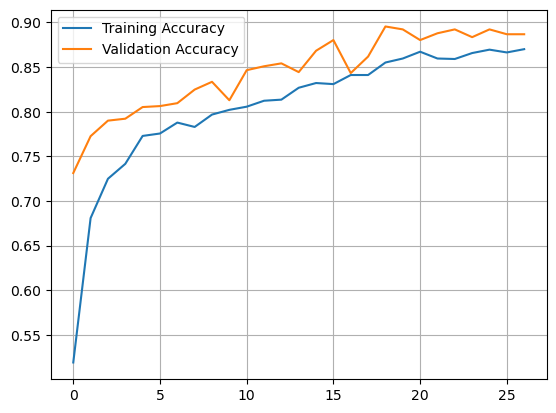

In [27]:
# vit
def plot_history_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy(history=history)

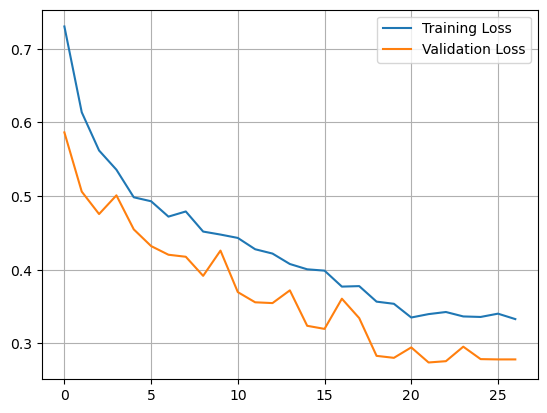

In [28]:
# vit
def plot_history_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss(history=history)

In [29]:
# vit
predictions = model.predict(test_gen, steps=test_steps ,verbose = True)
predictions = (predictions >= 0.5).astype(int)

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 362ms/step


In [28]:
# sam
print(classification_report(test_labels, predictions, target_names=['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.86      0.92      0.89       460
Pneumonia (Class 1)       0.91      0.85      0.88       459

           accuracy                           0.88       919
          macro avg       0.89      0.88      0.88       919
       weighted avg       0.89      0.88      0.88       919



In [30]:
# vit
print(classification_report(test_labels, predictions, target_names=['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.84      0.94      0.89       460
Pneumonia (Class 1)       0.93      0.82      0.87       459

           accuracy                           0.88       919
          macro avg       0.89      0.88      0.88       919
       weighted avg       0.89      0.88      0.88       919



In [31]:
# vit
cm = confusion_matrix(test_labels,predictions)
cm

array([[431,  29],
       [ 81, 378]], dtype=int64)

In [30]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

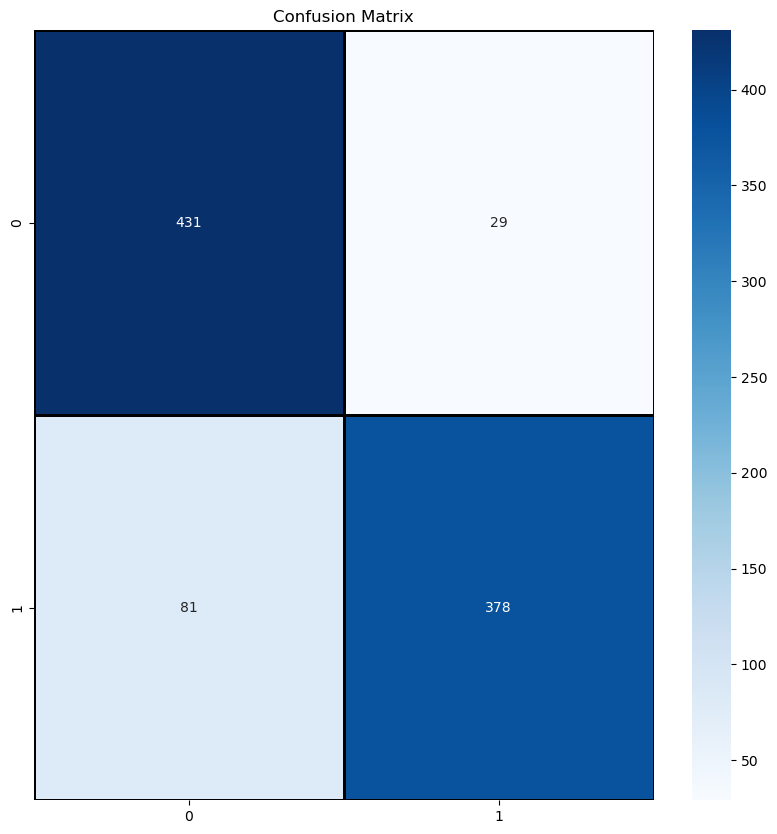

In [33]:
# vit
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix')
plt.show()

In [29]:
# # # load the best weights
# model.load_weights('vit_pneumonia_weights.best.weights.h5')

In [22]:
import keras_tuner as kt
import tensorflow as tf
from keras.src.layers import Layer, LayerNormalization, MultiHeadAttention, Dense, Dropout
from keras import Sequential
from keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Input

# def __init__(self, num_classes, num_layers= 8, num_heads= 6, D=64, mlp_dim= 256, patch_size= 4, image_size= 28, dropout= 0.1, norm_eps= 1e-12):

# Define your ViT model function to use hyperparameters
def build_vit_model(hp):
    # Hyperparameters
    num_classes = 1  
    num_layers = hp.Int('num_layers', min_value=4, max_value=12, step=2)
    num_heads = hp.Int('num_heads', min_value=4, max_value=12, step=2)
    D = hp.Int('D', min_value=32, max_value=768, step=32)
    mlp_dim = hp.Int('mlp_dim', min_value=128, max_value=2048, step=128)
    patch_size = hp.Int('patch_size', min_value=4, max_value=16, step=4)
    image_size = 28
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    norm_eps = 1e-12

    img_size = image_size
    channel = 1
    train_batch_size= TRAIN_BATCH_SIZE
    valid_test_batch_size= VALID_TEST_BATCH_SIZE
    
    inputs = Input(shape=(img_size, img_size, channel)) 
    vit_model = ViT(num_classes=num_classes,
                num_layers=num_layers,
                num_heads=num_heads,
                D=D,
                mlp_dim=mlp_dim,
                patch_size=patch_size,
                image_size=image_size,
                dropout=dropout,
                norm_eps=norm_eps)
    
    outputs = vit_model(inputs)  
    
    model = Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-2, sampling='log')

    
    optimizer = kr.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
      )

    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Create the Hyperband tuner
tuner = kt.Hyperband(
    build_vit_model,  # The model-building function
    objective='val_accuracy',  # The objective to optimize
    directory='best_hypter_parameter',  # Directory to store the results
    project_name='vit_tuning'  # Name of the project,
)

# Run the search for the best hyperparameters
tuner.search(train_gen,
            steps_per_epoch=train_steps,
            validation_data=valid_gen,
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hp.values}")


Trial 254 Complete [00h 27m 07s]
val_accuracy: 0.8367791175842285

Best val_accuracy So Far: 0.8944504857063293
Total elapsed time: 7d 17h 16m 46s


D:\anaconda\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 194 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'num_layers': 6, 'num_heads': 8, 'D': 128, 'mlp_dim': 640, 'patch_size': 4, 'dropout': 0.2, 'learning_rate': 0.0002956959895066203, 'weight_decay': 1.909116236190611e-06, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0228'}
